# Abstract

This notebook performs feature selection using Recursive Feature Elimination (RFE). We used sklearn's RFECV package which implements RFE with CV for more robust results. RFE in particular works as follows: Given an estimator that assigns weights to features (i.e. coeffcients of a linear model), RFE selects features by recursively considering smaller and smaller sets of features. Initially, the estimator is trained using the whole set and the importance of each feature is calculated. Then, the
least important features are pruned and the procedure is recursively repeated.

We performed feature selection for the two out of the total three models used for the Linear Bidding Strategy, namely Logistic Regression and Random Forest. Feature Selection for XGBoost didn't take place since it was extremely computationally expensive. 

# Import and Basic Info

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Set a random seed for repeatability
rand_seed = 123
random.seed(rand_seed)
np.random.seed(rand_seed)

In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [3]:
train.shape, validation.shape

((2430981, 25), (303925, 25))

## Import dummy datasets

In [4]:
from sklearn.externals import joblib

X_resampled = joblib.load("X_train_resampled_pCTR.pkl")
y_resampled = joblib.load("y_train_resampled_pCTR.pkl")
X_validation = joblib.load("X_validation_pCTR.pkl")
y_validation = joblib.load("y_validation_pCTR.pkl")

In [5]:
X_resampled.shape, y_resampled.shape, X_validation.shape, y_validation.shape

((40000, 698), (40000,), (303925, 698), (303925,))

In [6]:
features_total_names = joblib.load("total_features_basebid.pkl")

In [7]:
len(features_total_names)

698

## Feature Selection 

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, \
                            precision_score, make_scorer
from sklearn.externals import joblib

### Recursive Feature Elimination

In [9]:
clf_name = ["Logistic Regression", "Random Forest"]
clf = [LogisticRegression(C = 0.1, random_state = rand_seed), RandomForestClassifier(n_estimators = 150, random_state = rand_seed)]

CPU times: user 3min 37s, sys: 22.1 s, total: 3min 59s
Wall time: 1min 3s
Optimal number of features for Logistic Regression is 638
CPU times: user 17min 6s, sys: 11.2 s, total: 17min 17s
Wall time: 17min 18s
Optimal number of features for Random Forest is 668


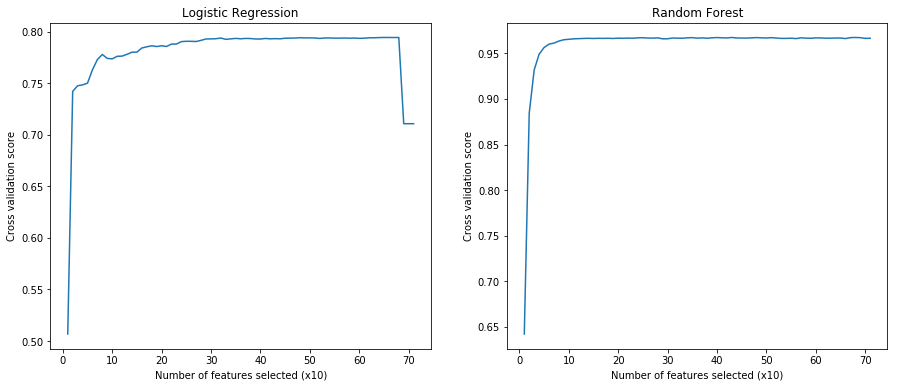

In [10]:
features_selected =  dict.fromkeys(clf_name)

plt.figure(figsize = (15,6))

for i in range(len(clf)):
    
    model = clf[i]
    
    # Initialize Recursive Feature Elimination object
    stepsize = 10
    rfecv = RFECV(estimator = model, step = stepsize, cv = StratifiedKFold(n_splits = 2), scoring = "f1_weighted")
    
    # Fit 
    % time rfecv.fit(X_resampled, y_resampled)
    
    # Number of important features
    print("Optimal number of features for {} is {}".format(clf_name[i], rfecv.n_features_))
    
    # Plot number of features VS. cross-validation scores
    plt.subplot(1,2,i+1)
    plt.xlabel("Number of features selected (x{})".format(stepsize))
    plt.ylabel("Cross validation score")
    plt.title(clf_name[i])
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    
    # Store feature importance to dict
    #feature_importance[i] = sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), train_dummy_2.columns))
    features_selected[clf_name[i]] = [f for f, s in zip(features_total_names, rfecv.support_) if s]
    
    # Export to pickle
    names = ["LR-Features.pkl", "RF-Features.pkl"]
    joblib.dump(features_selected[clf_name[i]], names[i])    